In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
from matplotlib.pyplot import rc_context
import scanpy as sc
from scipy import stats
import anndata as ad

# if IN_COLAB:
#     %matplotlib inline
%matplotlib inline
show_plot = True

In [6]:
# Convenient IPython console
# comment it if you execute Jupyterlab on a remote server
# %qtconsole --style monokai
# and use instead
%connect_info
# then jupyter qtconsole --style monokai --existing ./kernel.json
# or if remote: jupyter qtconsole --style monokai --existing ./kernel.json --ssh alexis@CRCT2112

{
  "shell_port": 62202,
  "iopub_port": 62203,
  "stdin_port": 62204,
  "control_port": 62206,
  "hb_port": 62205,
  "ip": "127.0.0.1",
  "key": "0607afd8-99b1eebb41764f81d67f856d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e5c03930-9456-4fd1-a2ff-23f93ff1a197.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [7]:
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [8]:
#import and read data

In [9]:
from glob import glob
# detect all matrix files
path_raw = list(glob('E:/scRNAseq/scRNA_Seq/processed/count cell ranger/*/'))
path_samples =  [i + 'filtered_feature_bc_matrix.h5' for i in path_raw]
results_file = '../data/intermediate/all_samples.h5ad'

In [10]:
adatas = [sc.read_10x_h5(filename, gex_only=False) for filename in path_samples]

C:\Users\Anna\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Anna\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Anna\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Anna\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Anna\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils

In [11]:
adatas

[AnnData object with n_obs × n_vars = 1524 × 33538
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 6514 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 5221 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 6744 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 3618 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 2871 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 2074 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 2591 × 36601
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 2938 × 33538
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 141 × 33538
     var: 'gene_ids', 'feature_types', 'genome',
 

In [14]:
for i, adata in enumerate(adatas):
    adata.var_names_make_unique()
    adata.obs['sample'] = sample_names[i]

In [15]:
# concatenate the datasets
# adata = adatas[0].concatenate(adatas[1:])
adata = ad.concat(adatas, merge="same")
# dataset.subsample_genes(4000)

C:\Users\Anna\anaconda3\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
adata.obs_names_make_unique()

In [11]:
#data normalization and filtering

In [12]:
samples_size = adata.obs['sample'].value_counts().sort_index()

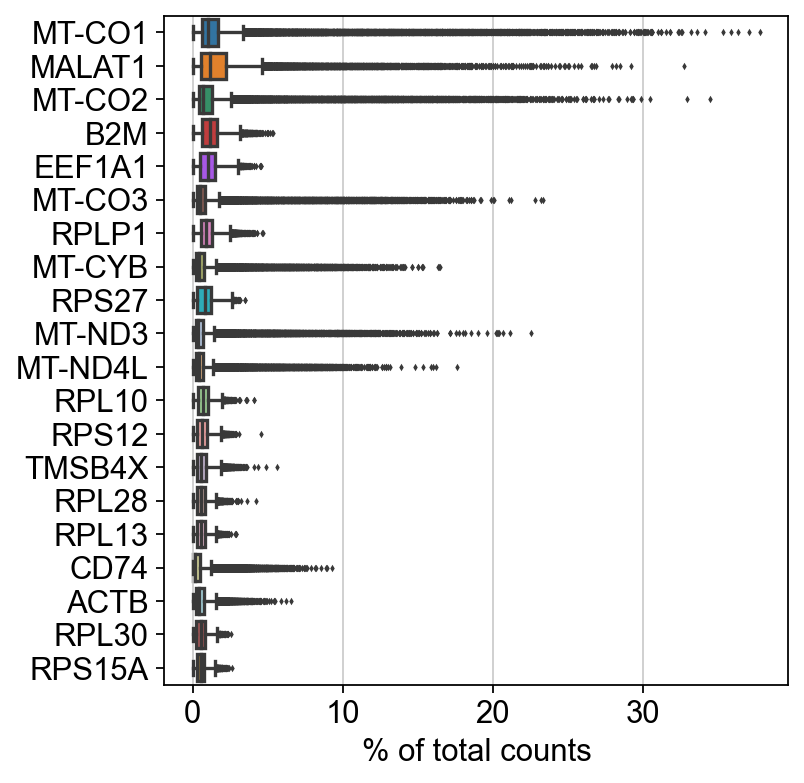

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [14]:
sc.pp.filter_cells(adata, min_genes = 250)
sc.pp.filter_genes(adata, min_cells = 3)

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [16]:
adata.var[adata.var.index == 'FAP']

feature_types  genome  n_cells     mt  n_cells_by_counts  mean_counts  \
FAP  Gene Expression  GRCh38     1762  False               1762     0.088916   

     pct_dropout_by_counts  total_counts  
FAP              96.637276        4659.0

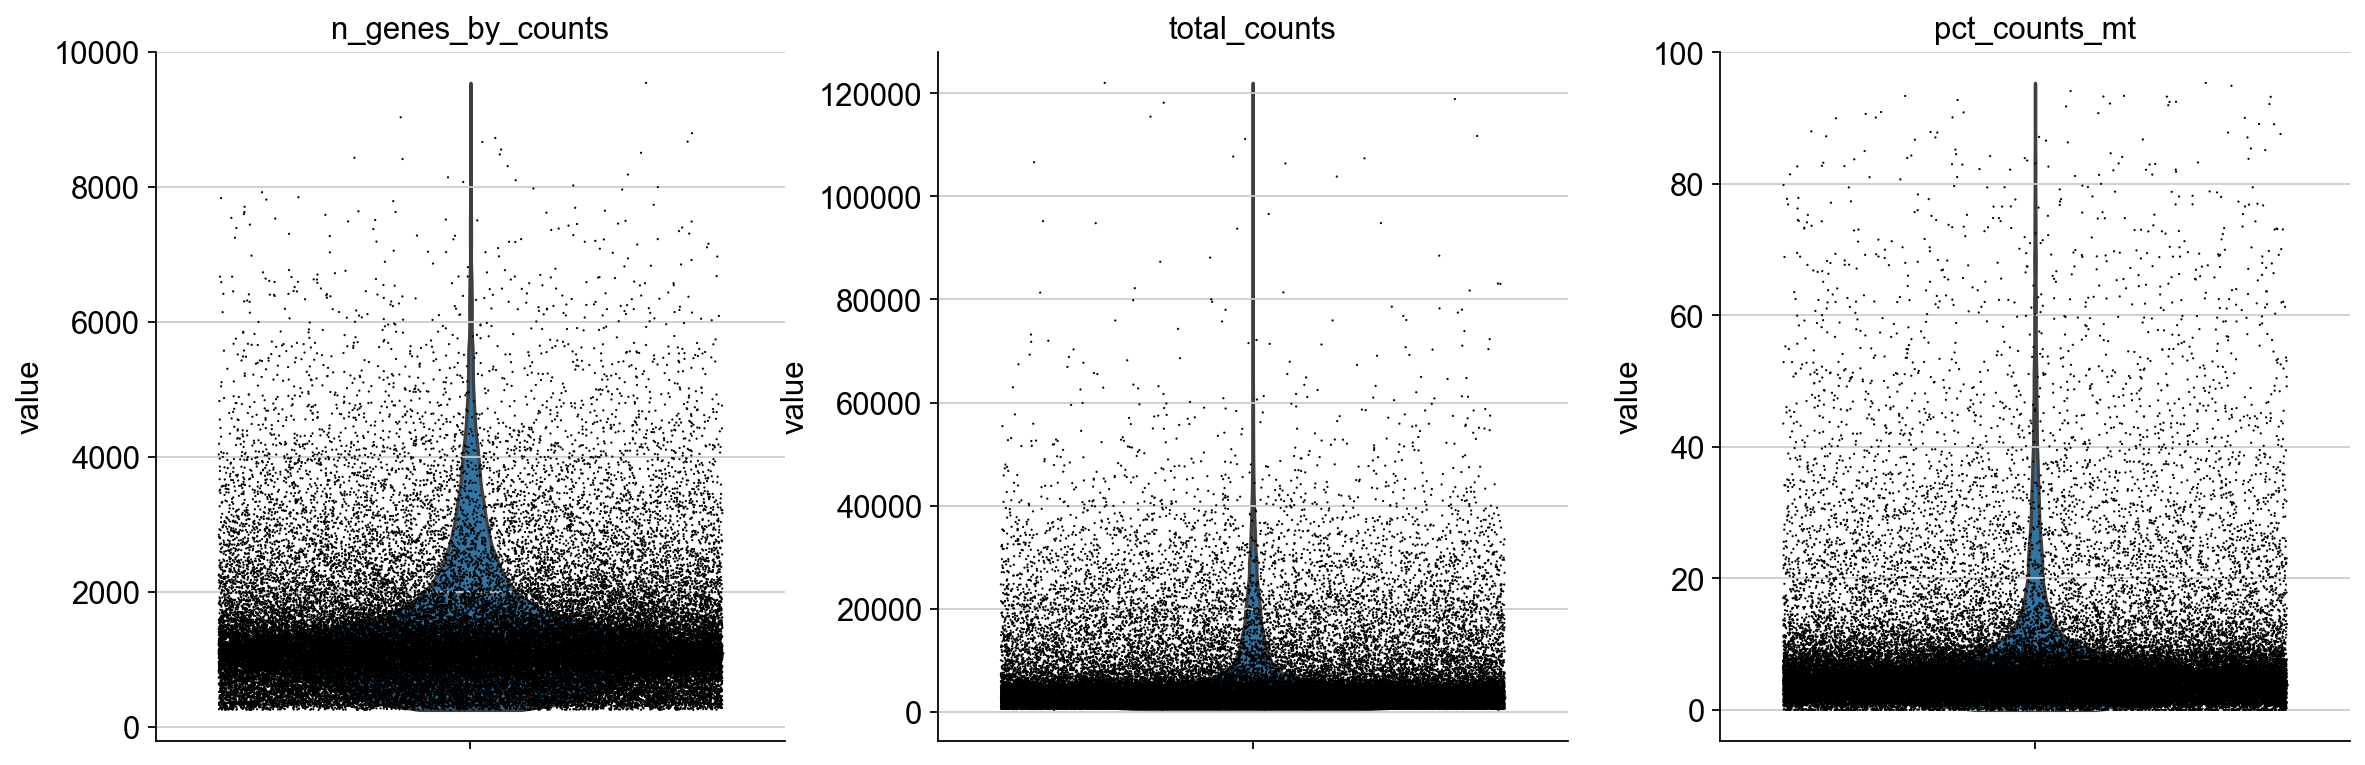

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

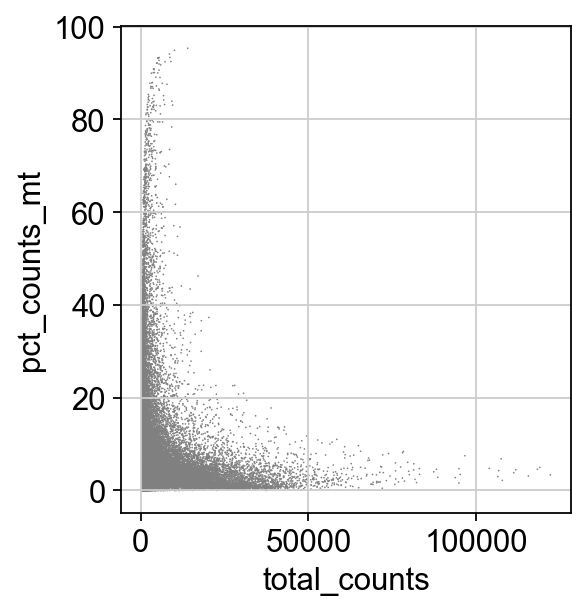

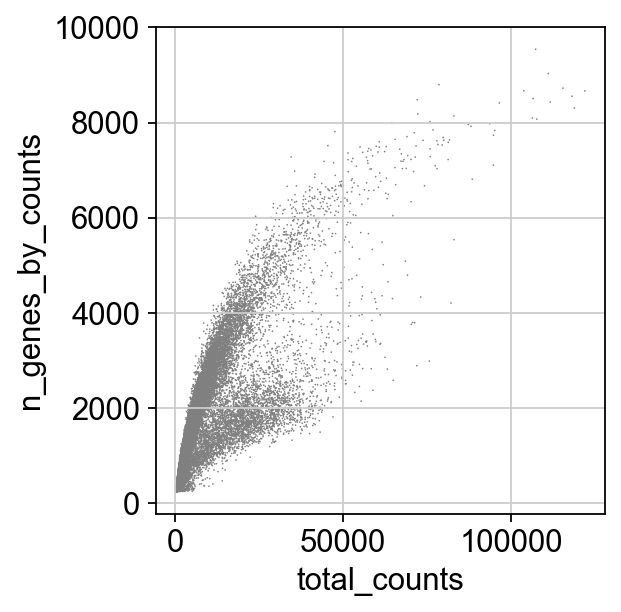

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 17, :]

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

C:\Users\Anna\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
adata.X

<43207x23913 sparse matrix of type '<class 'numpy.float32'>'
	with 50100629 stored elements in Compressed Sparse Row format>

In [22]:
sc.pp.log1p(adata)

In [23]:
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

In [24]:
adata.raw = adata

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
adata.var

feature_types  genome  n_cells     mt  n_cells_by_counts  \
HES4        Gene Expression  GRCh38     4568  False               4568   
ISG15       Gene Expression  GRCh38    13213  False              13213   
AGRN        Gene Expression  GRCh38     2287  False               2287   
TNFRSF18    Gene Expression  GRCh38     7117  False               7117   
TNFRSF4     Gene Expression  GRCh38     6573  False               6573   
...                     ...     ...      ...    ...                ...   
COL6A1      Gene Expression  GRCh38     3983  False               3983   
COL6A2      Gene Expression  GRCh38     4631  False               4631   
S100B       Gene Expression  GRCh38     1241  False               1241   
AC233755.2  Gene Expression  GRCh38       82  False                 82   
AC233755.1  Gene Expression  GRCh38      341  False                341   

            mean_counts  pct_dropout_by_counts  total_counts  highly_variable  \
HES4           0.257319              91.282110       13483.0             True   
ISG15          0.616283              74.783389       32292.0             True   
AGRN           0.096759              95.635330        5070.0             True   
TNFRSF18       0.305202              86.417421       15992.0             True   
TNFRSF4        0.388259              87.455628       20344.0             True   
...                 ...                    ...           ...              ...   
COL6A1         0.577293              92.398565       30249.0             True   
COL6A2         1.139433              91.161876       59704.0             True   
S100B          0.225428              97.631589       11812.0             True   
AC233755.2     0.211458              99.843505       11080.0             True   
AC233755.1     1.753846              99.349212       91898.0             True   

               means  dispersions  dispersions_norm  
HES4        0.234650     2.310423          1.298046  
ISG15       0.767033     2.403022          0.528163  
AGRN        0.047511     1.916819          0.585961  
TNFRSF18    0.611196     2.490733          0.619375  
TNFRSF4     0.740108     3.334865          1.497198  
...              ...          ...               ...  
COL6A1      0.233489     2.675092          1.957784  
COL6A2      0.450997     3.224078          2.499475  
S100B       0.181503     3.524245          3.494022  
AC233755.2  0.136387     6.986186          9.757161  
AC233755.1  0.626463     7.488070          5.816166  

[1747 rows x 12 columns]

In [27]:
adata.X

<43207x1747 sparse matrix of type '<class 'numpy.float32'>'
	with 2018458 stored elements in Compressed Sparse Row format>

In [28]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [29]:
sc.pp.scale(adata, max_value=10)

In [30]:
sc.tl.pca(adata, svd_solver='arpack')

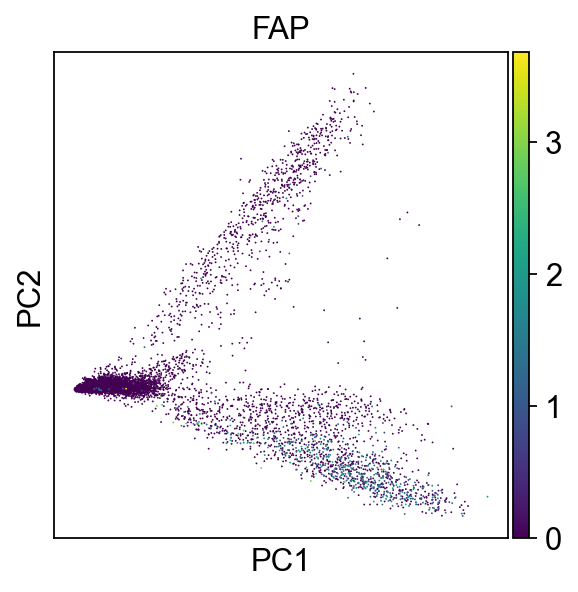

In [31]:
sc.pl.pca(adata, color='FAP')

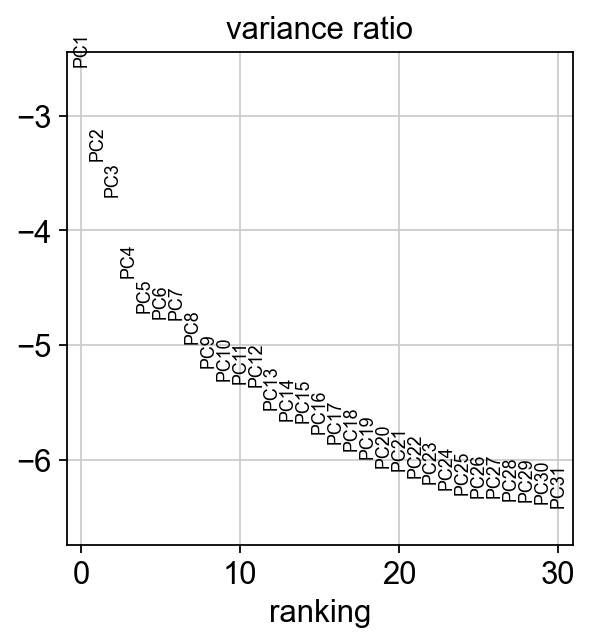

In [32]:
sc.pl.pca_variance_ratio(adata, log=True)

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=27)

In [34]:
sc.tl.umap(adata)

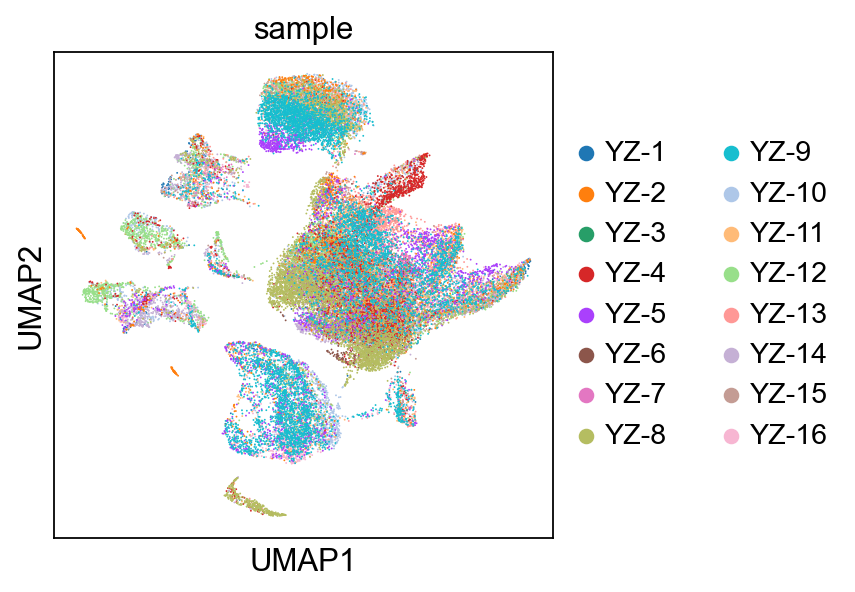

In [35]:
sc.pl.umap(adata, color = 'sample')

In [36]:
#implementation of leiden clusterization algorith (I personally prefer louvain)

In [37]:
sc.tl.leiden(adata)

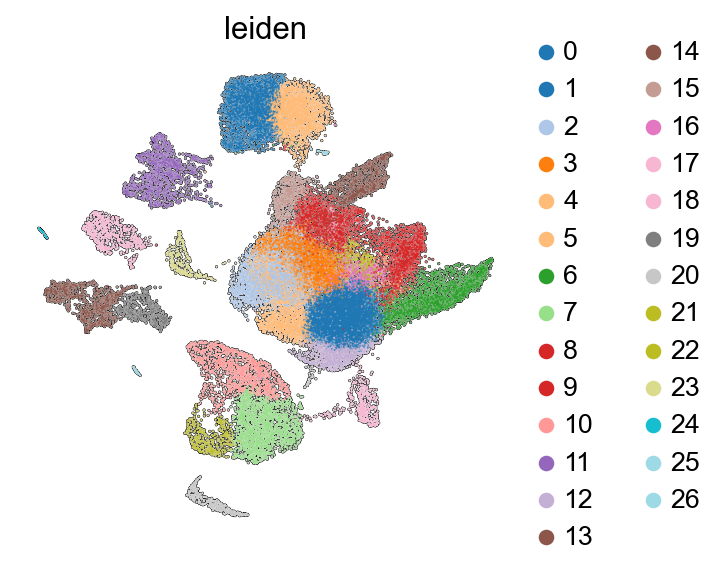

In [38]:
sc.pl.umap(adata, color = 'leiden', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               palette='tab20')

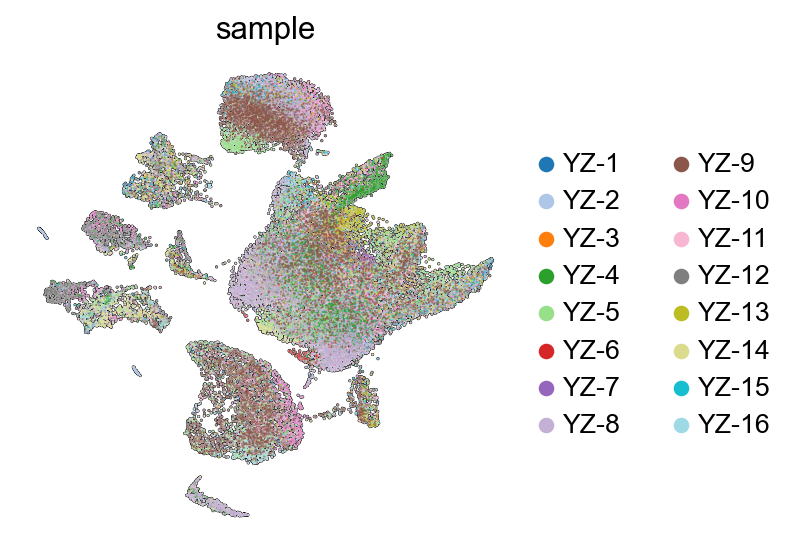

In [39]:
sc.pl.umap(adata, color = 'sample', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=False,
               palette='tab20')

In [41]:
#ranking of genes for every cluster

In [42]:
sc.settings.verbosity = 2

ranking genes


C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

    finished (0:05:43)


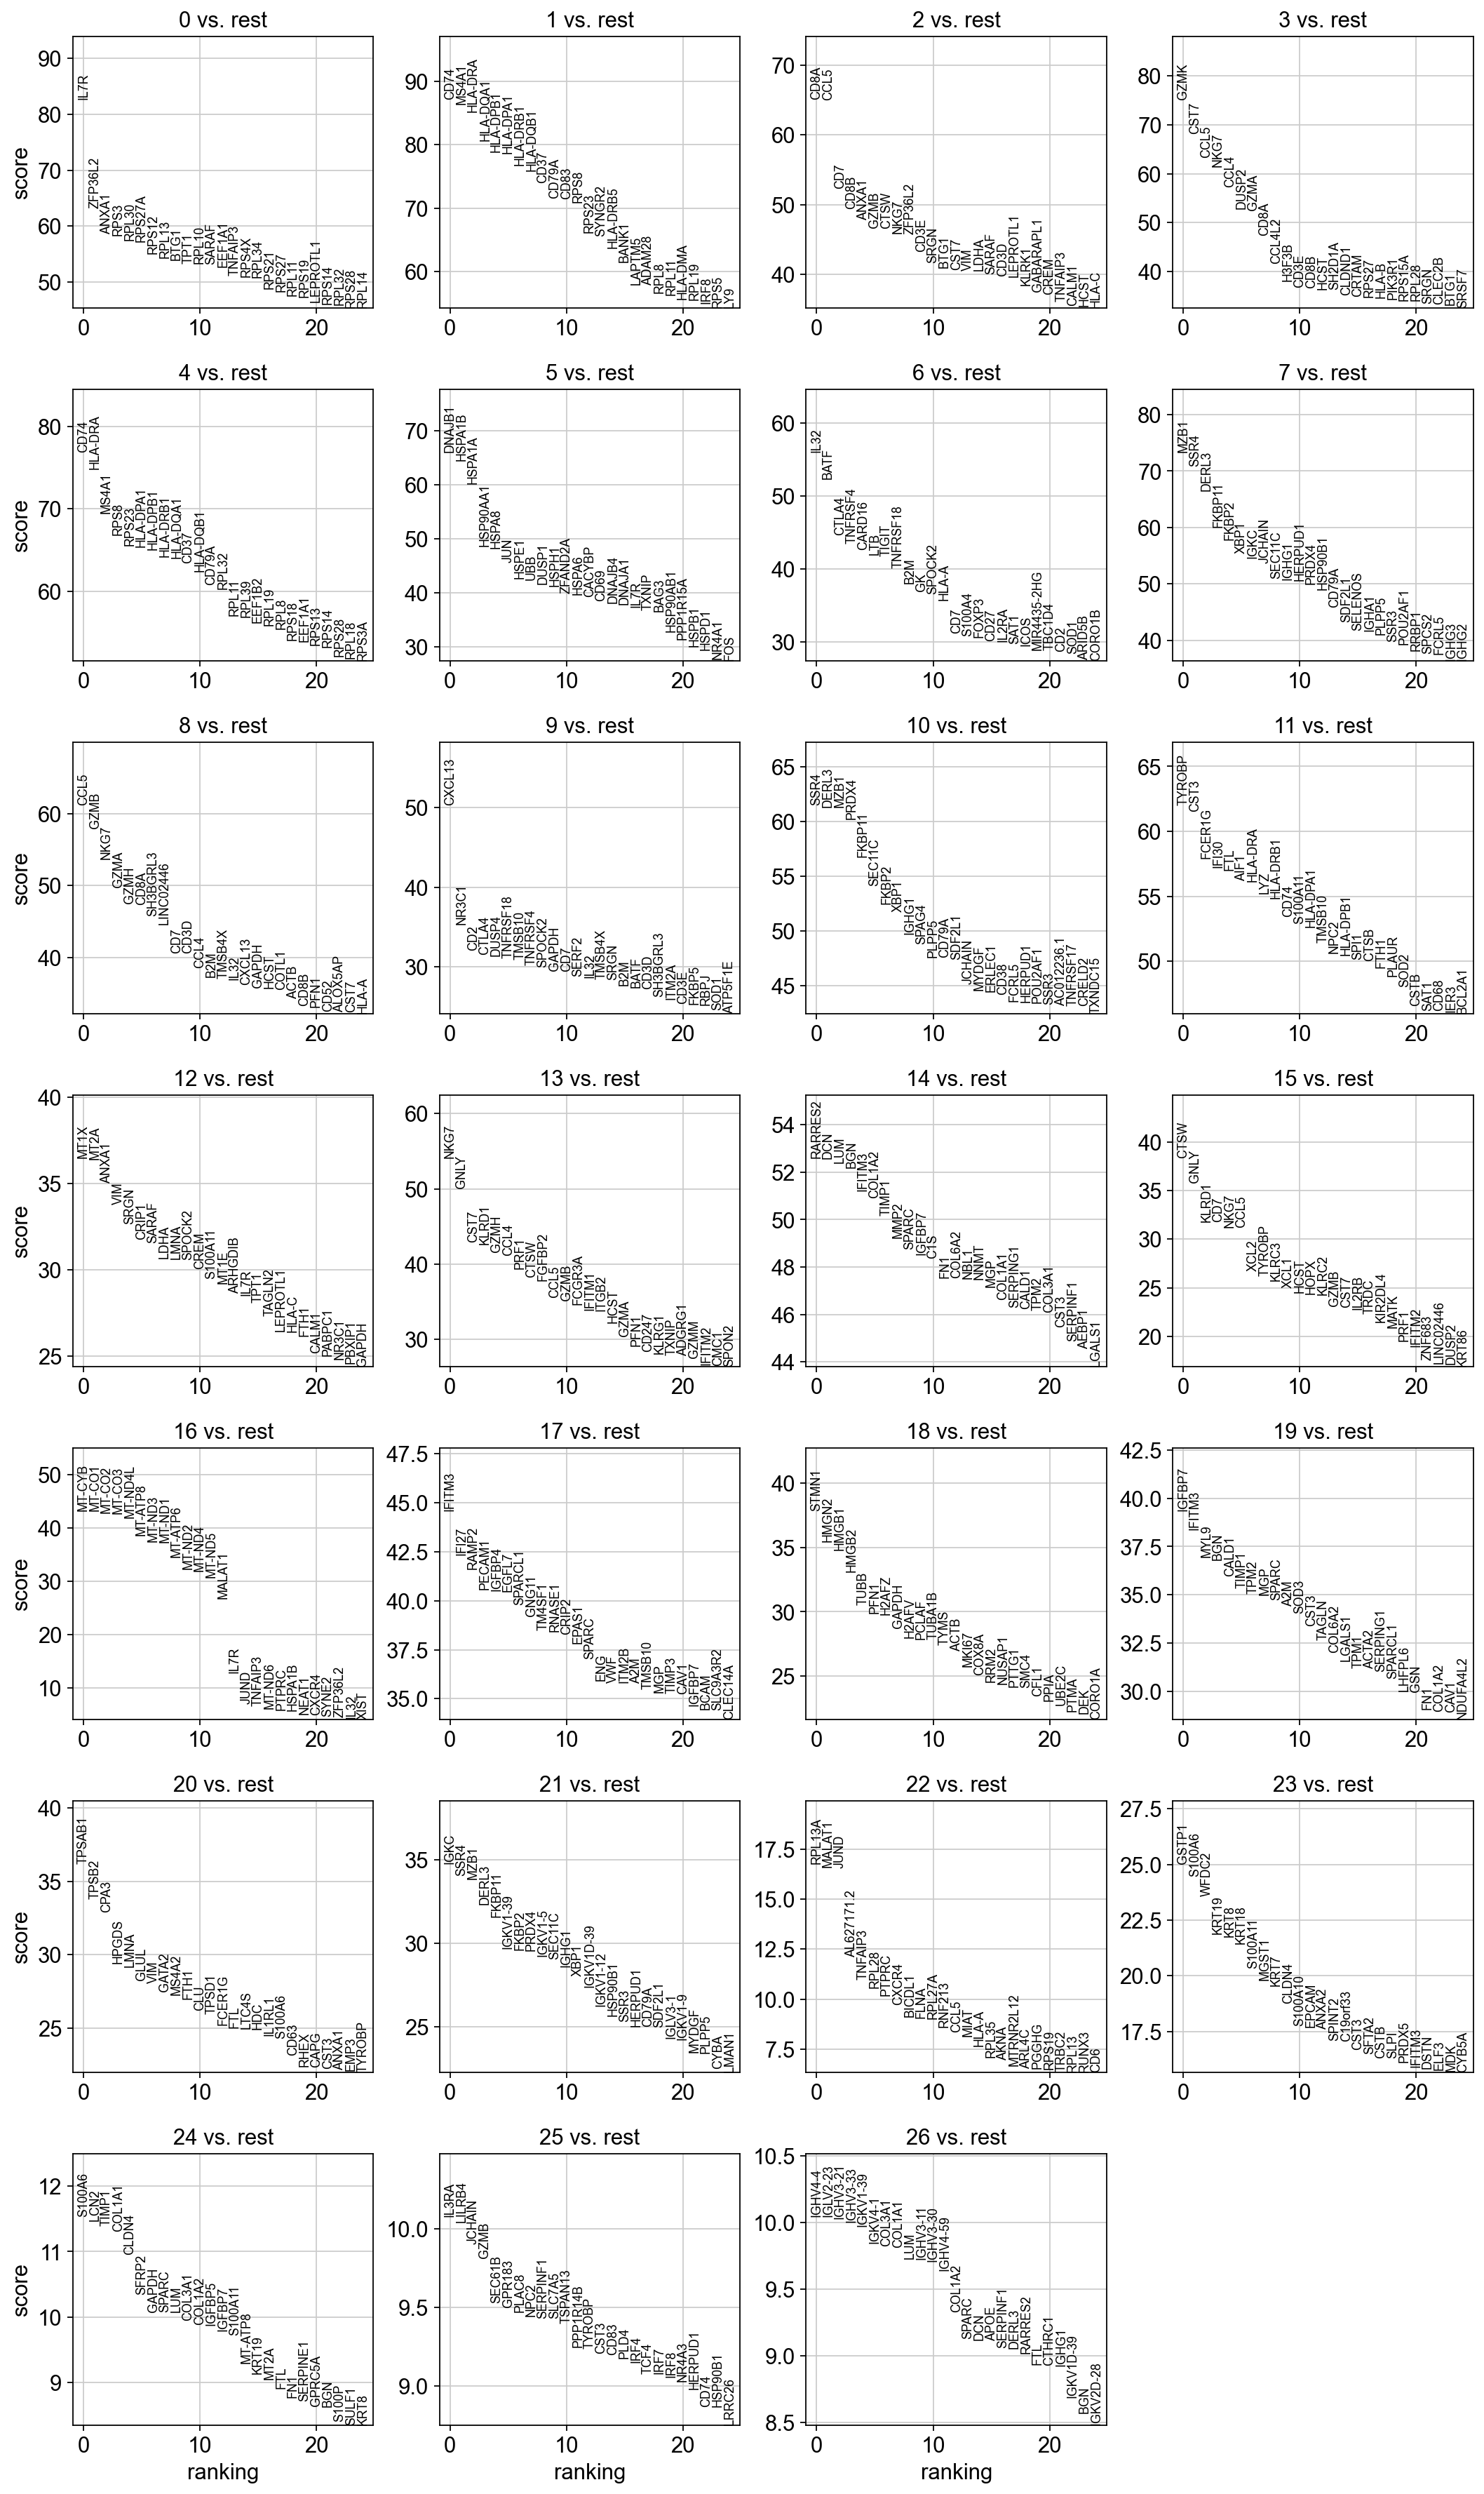

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [44]:
#removing batch effect

In [45]:
import harmonypy as hm

In [46]:
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, ['sample'])

2023-06-01 16:07:29,436 - harmonypy - INFO - Iteration 1 of 10
2023-06-01 16:07:56,775 - harmonypy - INFO - Iteration 2 of 10
2023-06-01 16:08:28,895 - harmonypy - INFO - Iteration 3 of 10
2023-06-01 16:08:58,730 - harmonypy - INFO - Converged after 3 iterations


In [47]:
adata.obsm['X_harmony'] = ho.Z_corr.T

In [48]:
sc.pp.neighbors(adata, use_rep='X_harmony')

sc.tl.umap(adata)

computing neighbors
    finished (0:00:04)
computing UMAP
    finished (0:00:42)


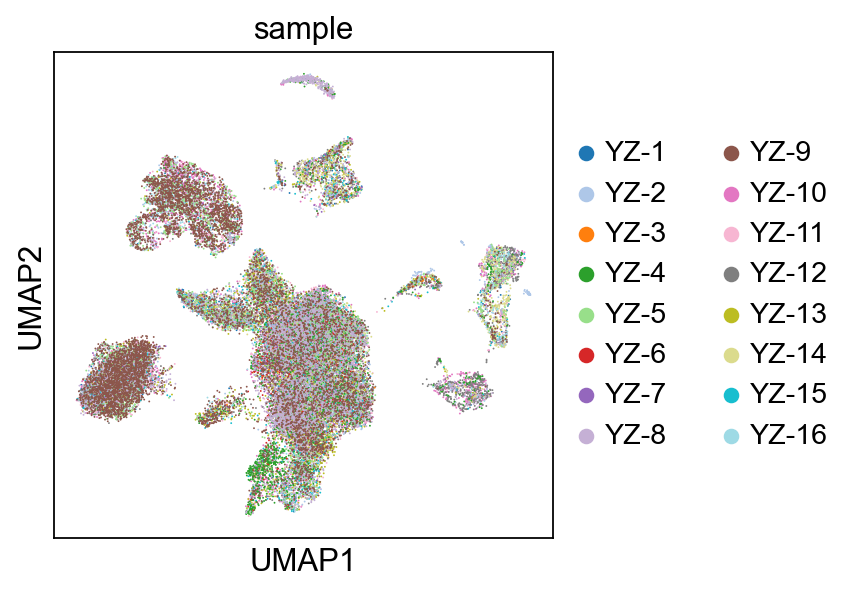

In [49]:
# plt.figure(figsize=(10,10))
# plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=adata.obs['sample'], alpha=0.1, s=3)
sc.pl.umap(adata, color=['sample'], palette='tab20')

In [50]:
#clusterization after batch effect was removed

In [51]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:25)


In [56]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes


C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

    finished (0:05:52)


C:\Users\Anna\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(


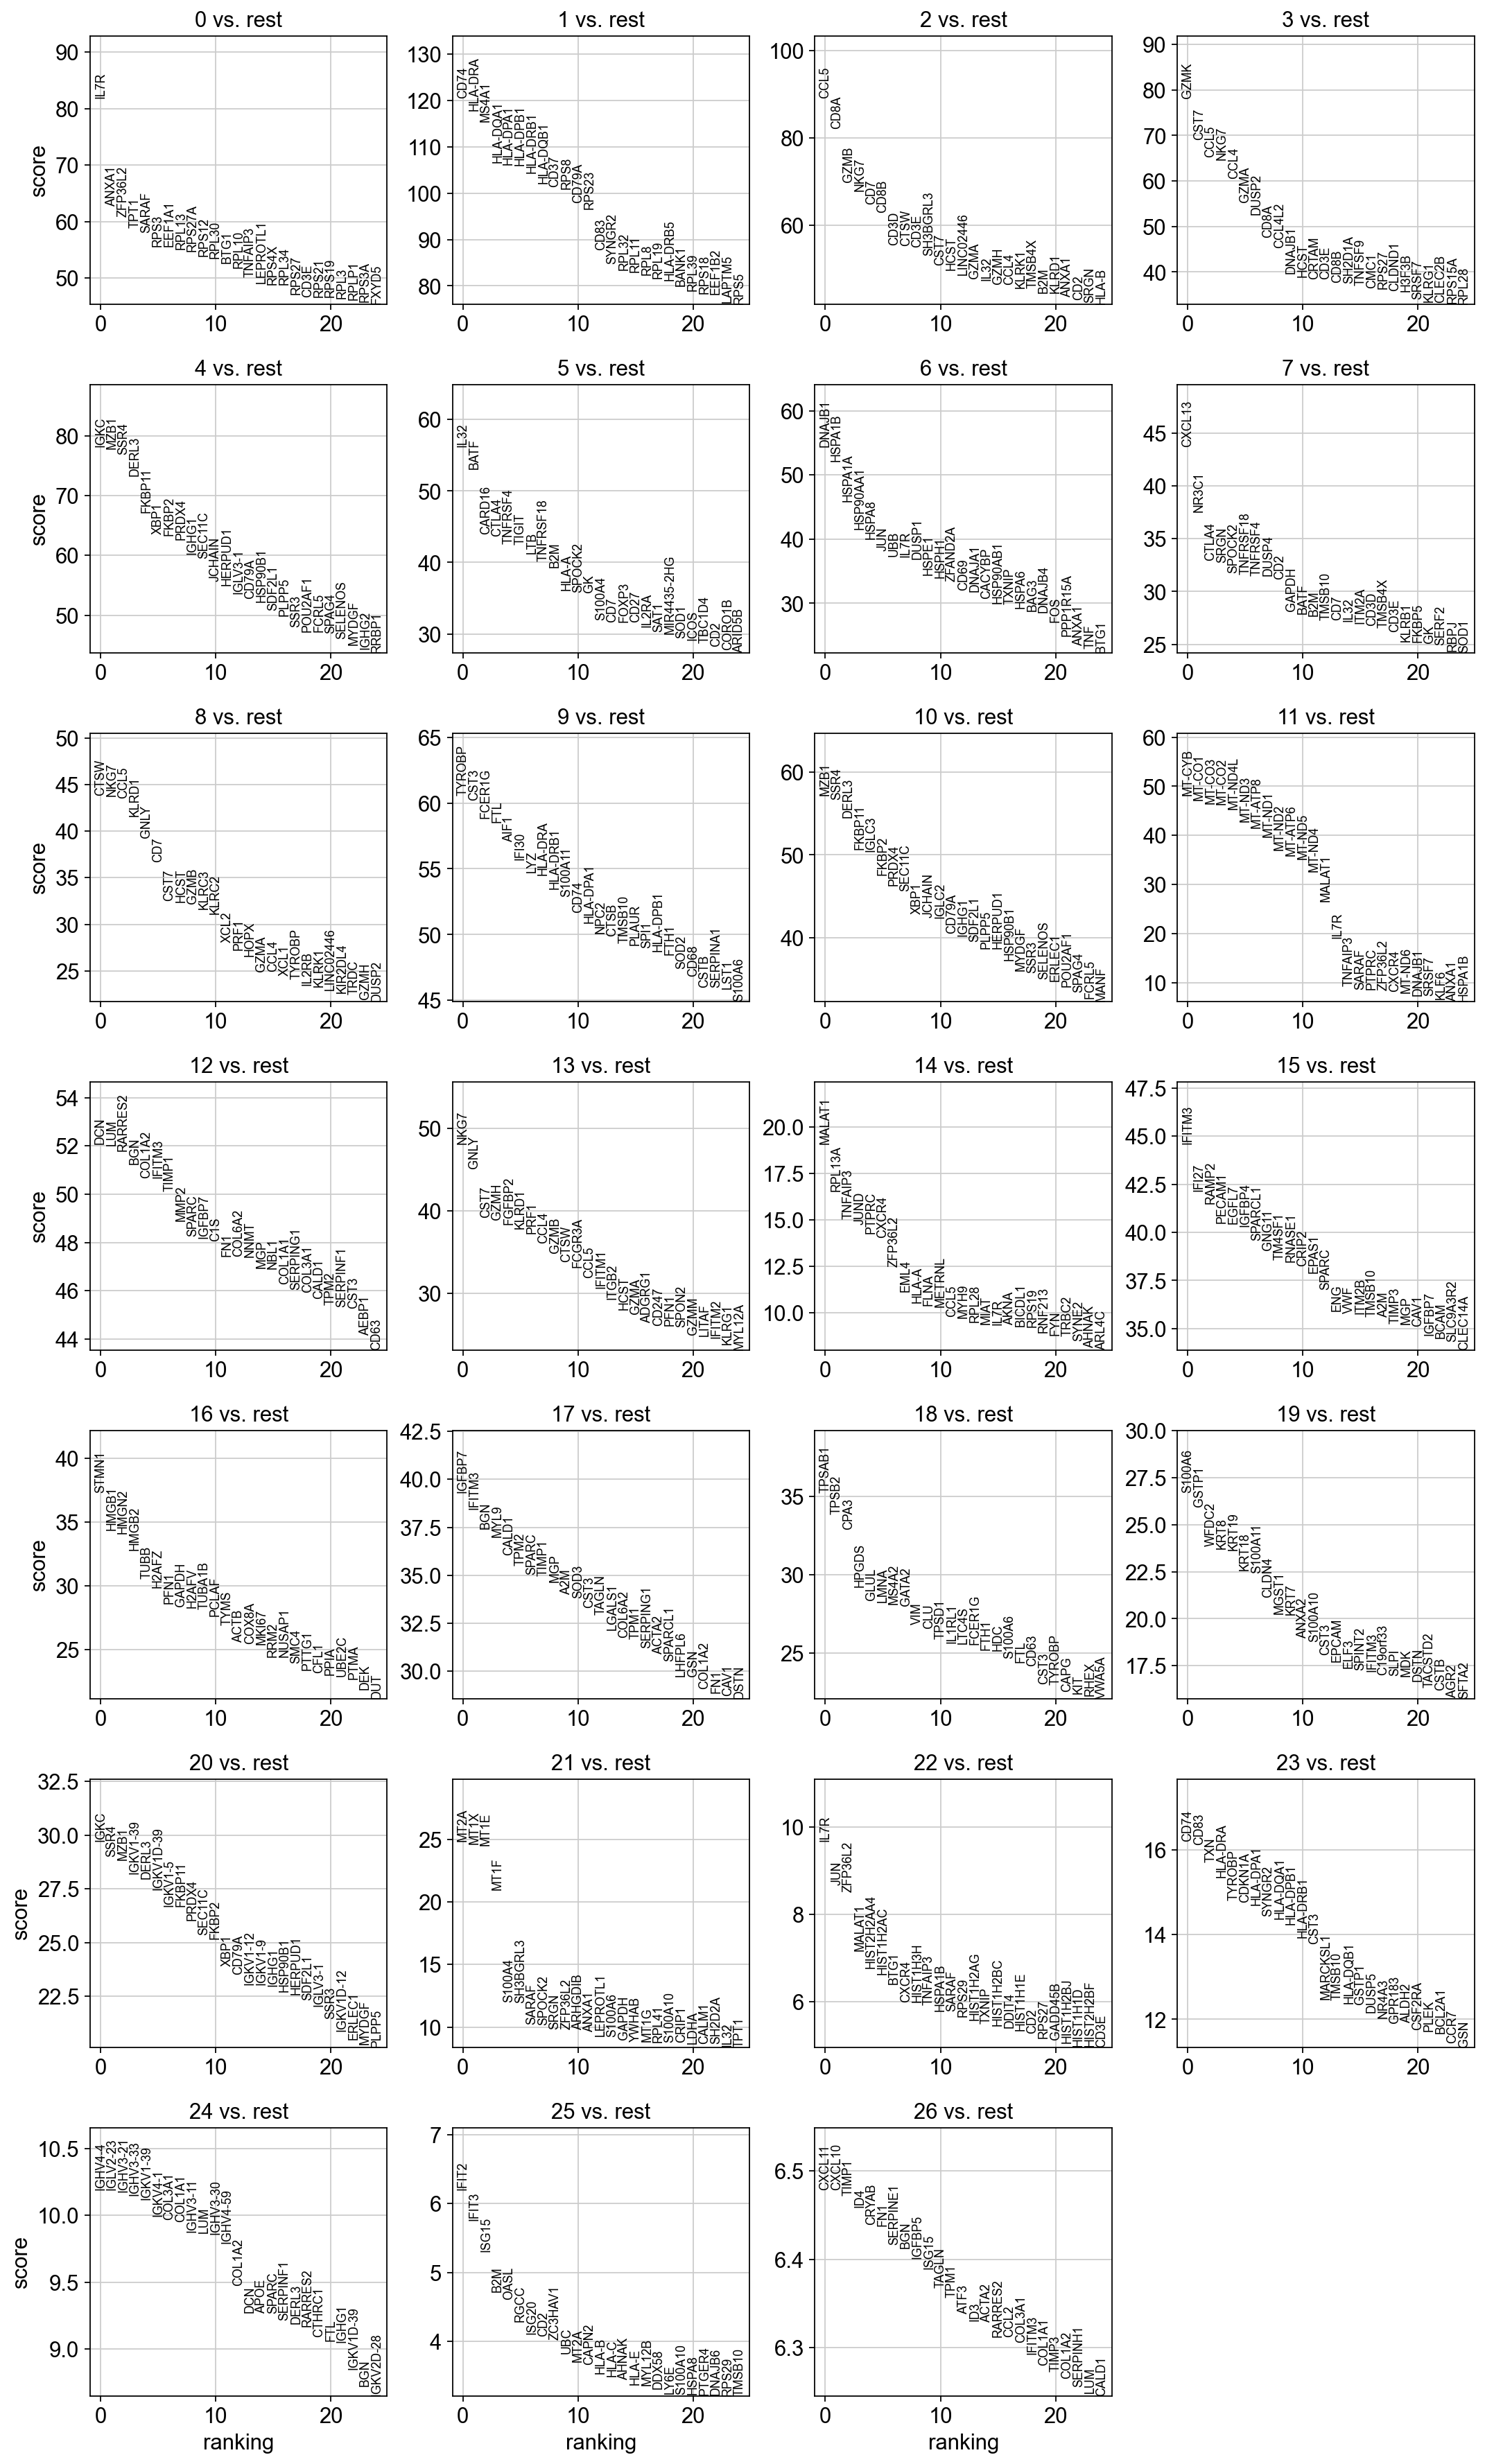

In [57]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [59]:
marker_genes = ['HAVCR2', 'BTLA', 'TIGIT', 'LAG3', 'PDCD1', 'CTLA4', 'IL4', 'KLRC1']
marker_genes = list(set(marker_genes))

In [60]:
marker_genes_ep = ['EPCAM', 'YAP1', 'TAZ', 'ACTA2', 'MMP2', 'MMP9', 'MMP11']
marker_genes_ep = list(set(marker_genes_ep))

In [61]:
#mannual annotation of patients data

In [17]:
sample_cancer_mapper = {'YZ-1': 'Aggressive',
                        'YZ-10': 'Aggressive',
                        'YZ-11': 'Indolent',
                        'YZ-12': 'Indolent',
                        'YZ-13': 'Aggressive',
                        'YZ-14': 'Indolent',
                        'YZ-15': 'Indolent',
                        'YZ-16': 'Aggressive',
                        'YZ-2': 'Aggressive',
                        'YZ-3': 'Indolent',
                        'YZ-4': 'Indolent',
                        'YZ-5': 'Aggressive',
                        'YZ-6': 'Indolent',
                        'YZ-7': 'Indolent',
                        'YZ-8': 'Indolent',
                        'YZ-9': 'Aggressive'}

In [18]:
adata.obs['cancer type'] = adata.obs['sample'].map(sample_cancer_mapper)

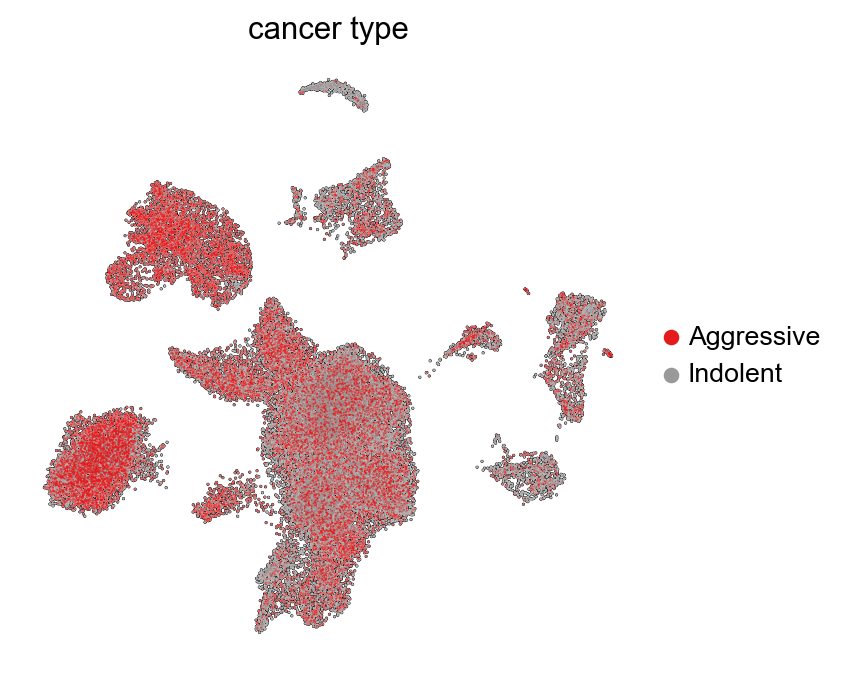

In [70]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'cancer type', edges_color = 'black', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette = 'Set1')

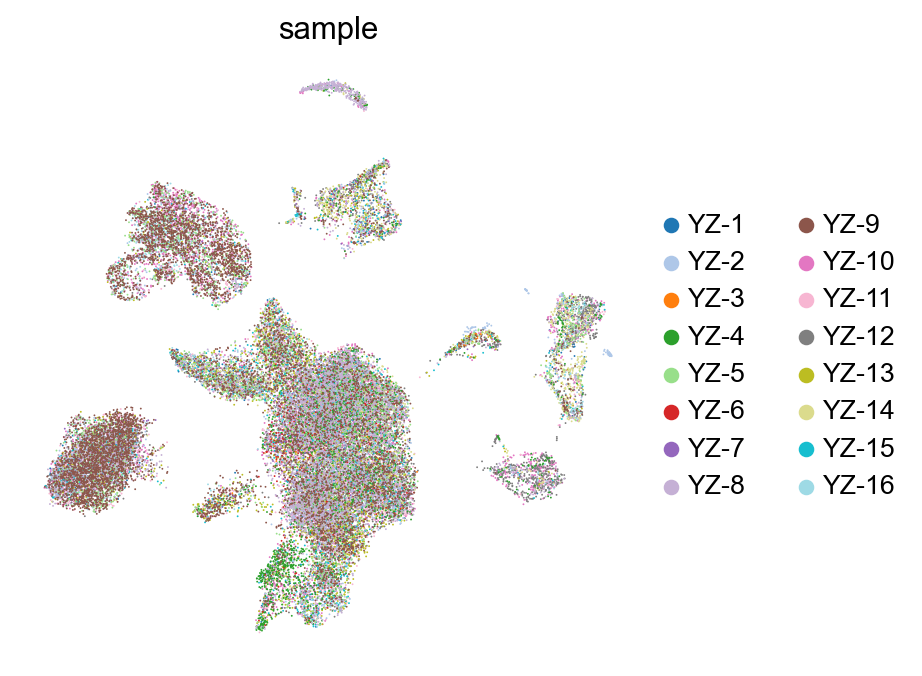

In [71]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'sample', legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette = 'tab20')

In [72]:
list_samples = ['YZ-1',
                'YZ-10',
                'YZ-11',
                'YZ-12',
                'YZ-13',
                'YZ-14',
                'YZ-15',
                'YZ-16',
                'YZ-2',
                'YZ-3', 
                'YZ-4', 
                'YZ-5',
                'YZ-6', 
                'YZ-7', 
                'YZ-8',
                'YZ-9']

In [73]:
list_type = ['Aggressive',
            'Aggressive',
            'Indolent',
            'Indolent',
            'Aggressive',
            'Indolent',
            'Indolent',
            'Aggressive',
            'Aggressive',
            'Indolent',
            'Indolent',
            'Aggressive',
            'Indolent',
            'Indolent',
            'Indolent',
            'Aggressive']

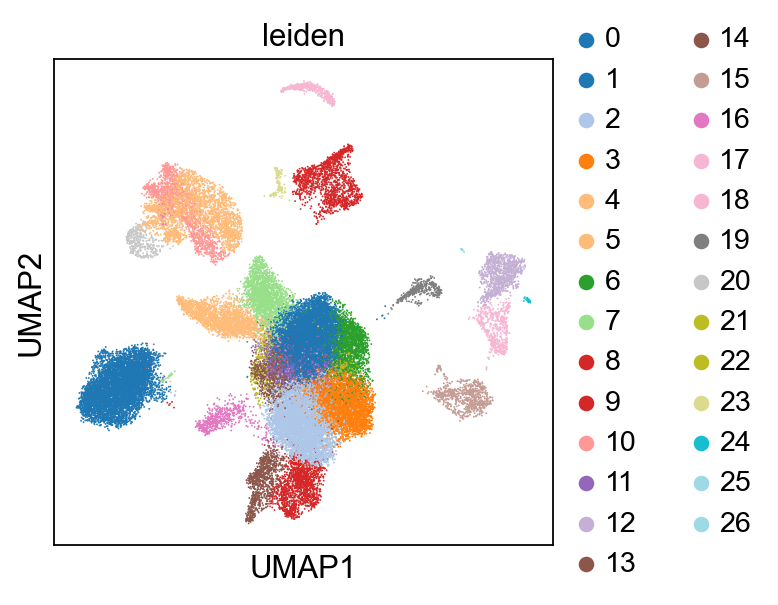

In [76]:
sc.pl.umap(adata, color=['leiden'])

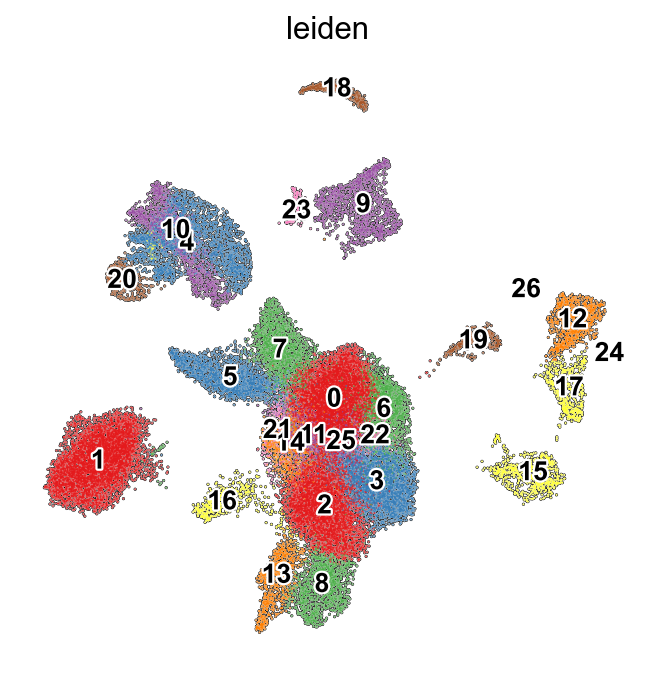

In [77]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'leiden', edges_color = 'black', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette = 'Set1')

In [78]:
#annotation of cell types (markers are below)

In [79]:
cluster2annotation = {
     '0': 'CD4+ T-cells',
     '1': 'B-cells',
     '2': 'CD8+ T-cells',
     '3': 'CD8+ T-cells',
     '4': 'Plasma cells',
     '5': 'CD4+ T-cells',
     '6': 'CD4+ T-cells',
     '7': 'CD4+ T-cells',
     '8': 'CD8+ T-cells',
     '9': 'Myeloid cells',
     '10': 'Plasma cells',
     '11': 'CD4+ T-cells',
     '12': 'Stromal',
     '13': 'NK cells',
     '14': 'CD4+ T-cells',
     '15': 'Endothelial',
     '16': 'CD8+ T-cells',
     '17': 'Stromal',
     '18': 'Mast cells',
     '19': 'Epithelial/Cancer',
     '20': 'Plasma cells',
     '21': 'CD4+ T-cells',
    '22': 'CD4+ T-cells',
    '23': 'Myeloid cells',
    '24': 'Stromal',
    '25': 'CD4+ T-cells',
    '26': 'Stromal'
}

adata.obs['cell type'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [80]:
set(adata.obs['cell type'])

{'B-cells',
 'CD4+ T-cells',
 'CD8+ T-cells',
 'Endothelial',
 'Epithelial/Cancer',
 'Mast cells',
 'Myeloid cells',
 'NK cells',
 'Plasma cells',
 'Stromal'}

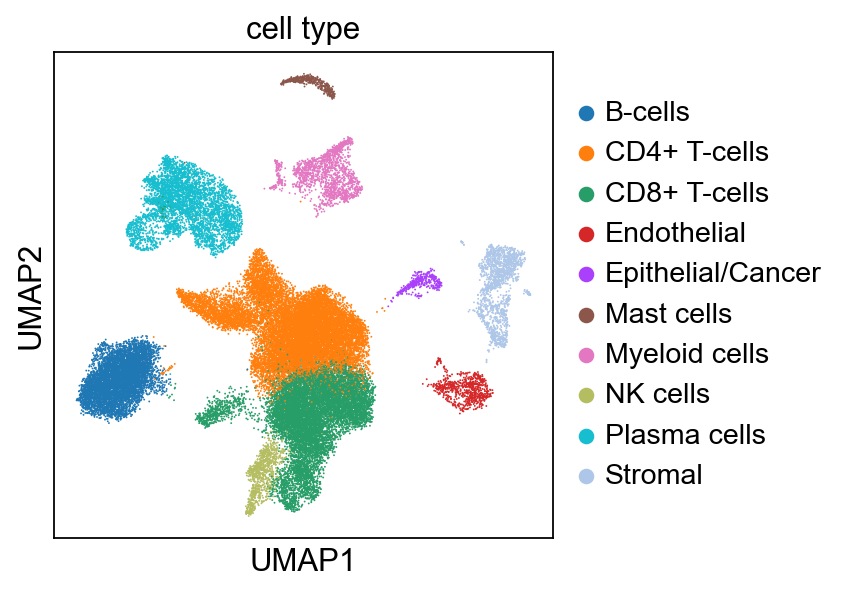

In [81]:
sc.pl.umap(adata, color=['cell type'])

In [82]:
sns.set()
sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

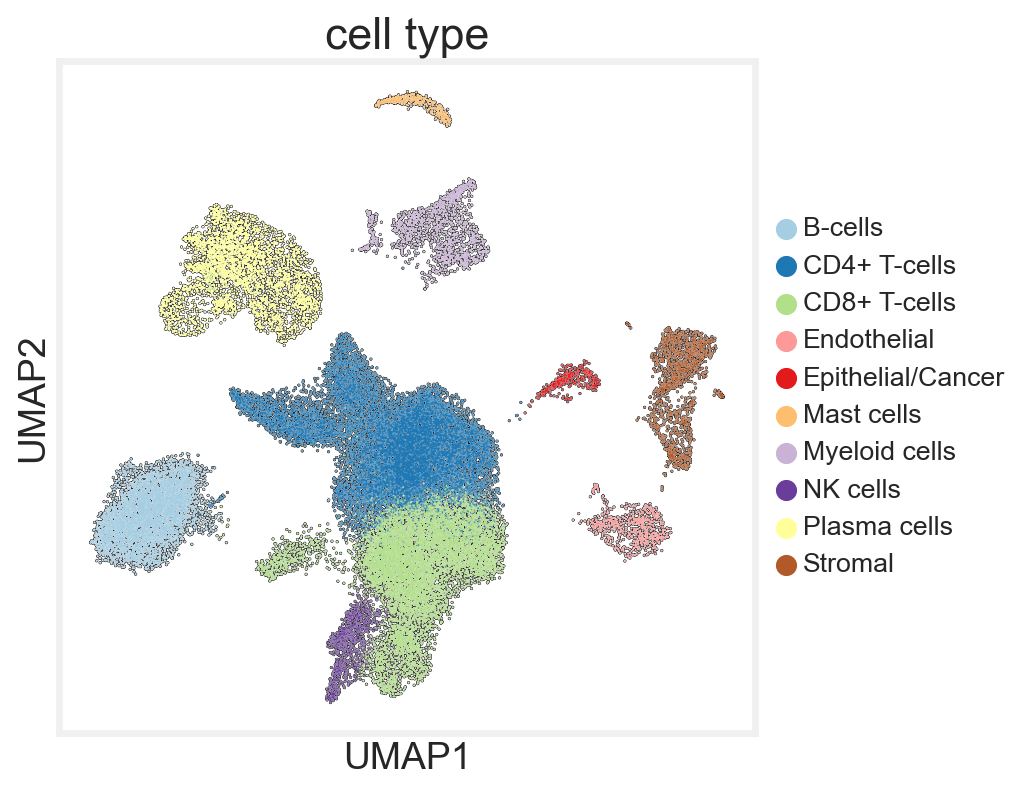

In [83]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'cell type', edges_color = 'black', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=True, palette = 'Paired')

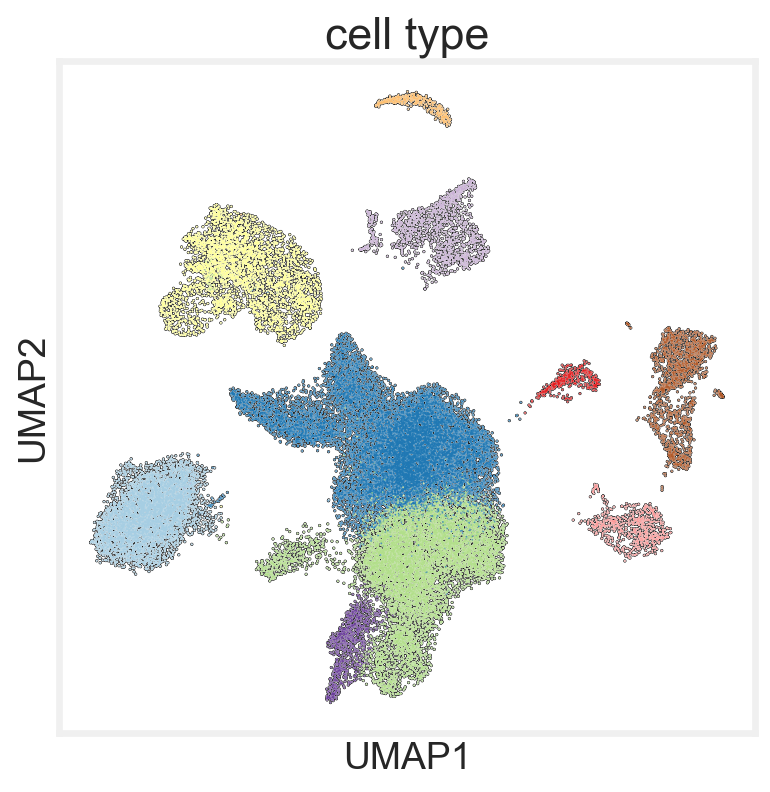

In [84]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'cell type', edges_color = 'black', add_outline=True, legend_loc='right margine',
               legend_fontsize=12, legend_fontoutline=2, frameon=True, palette = 'Paired')

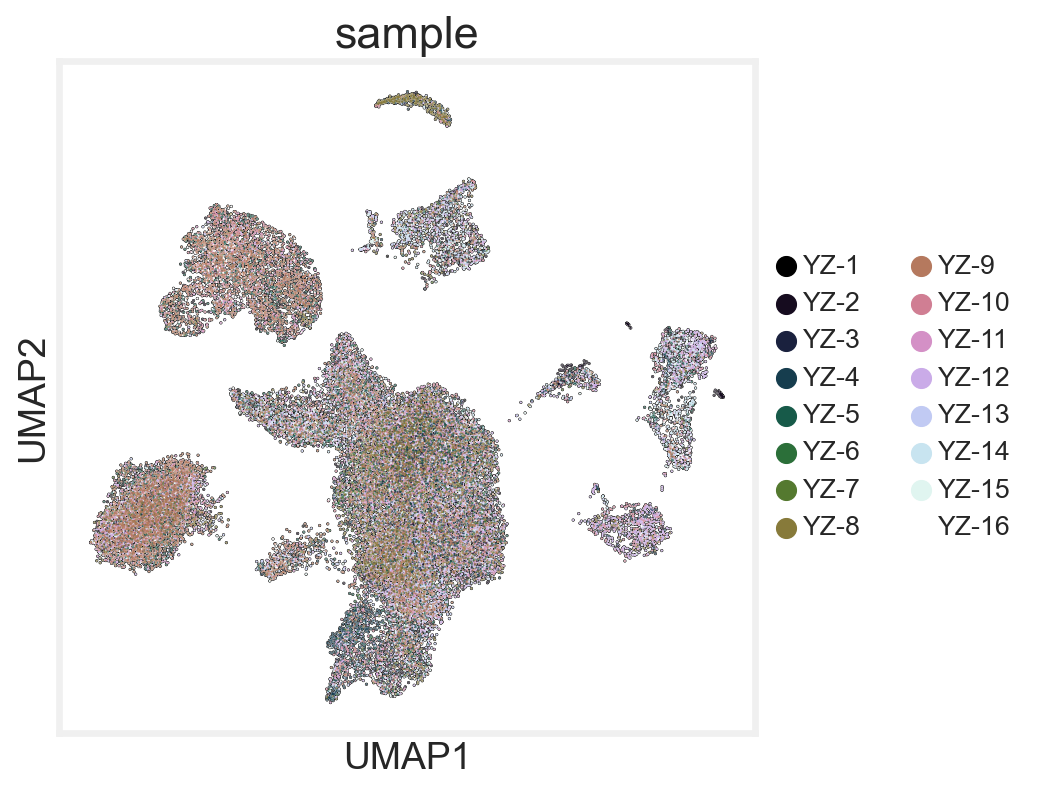

In [85]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'sample', edges_color = 'black', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=True, palette = "cubehelix")

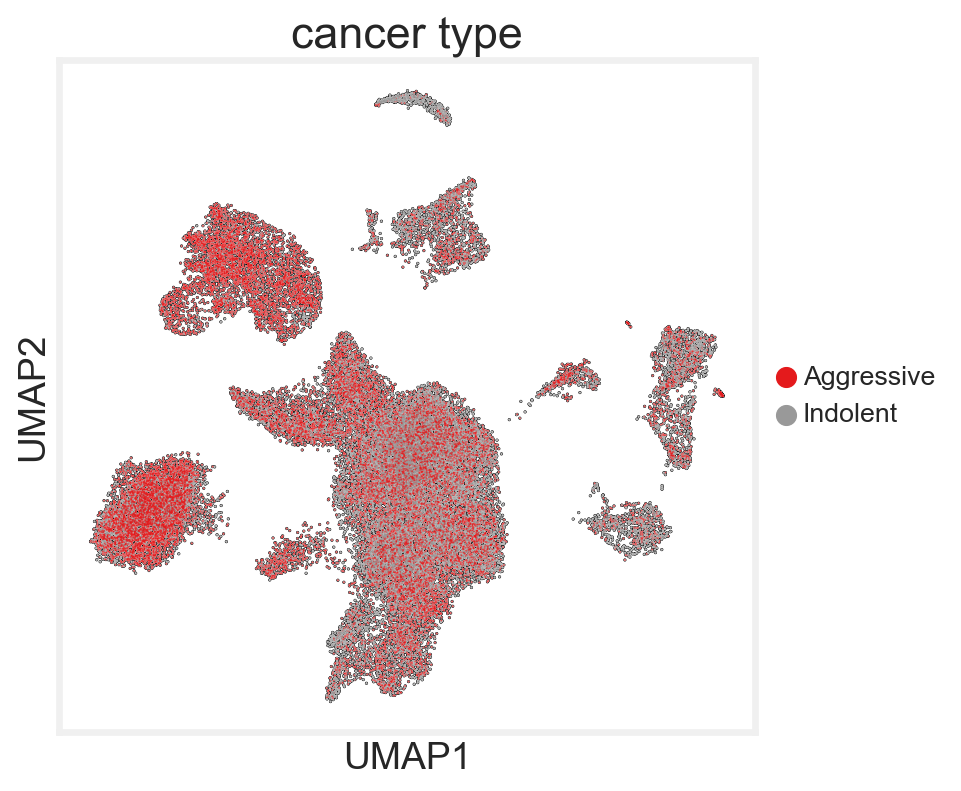

In [86]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color = 'cancer type', edges_color = 'black', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2, frameon=True, palette = 'Set1')

In [87]:
#markers

In [88]:
list_of_markers = ['CLDN5',
                   'FLT1',
                   'VWF',
                   'PECAM1',
                   'KDR',
                   'CDH5',
                   'ANGPT2',
                   'ACKR1',
                   'CAPS',
                   'SNTN',
                   'TFF3',
                   'CDH1',
                   'FOXJ1',
                   'LUM',
                   'COL1A1',
                   'COL1A2',
                   'DCN',
                   'C1R',
                   'LYZ',
                   'CD14',
                   'CD68',
                   'FCGR1A',
                   'FCGR3A',
                   'MNDA',
                   'CD2',
                   'CD3D',
                   'CD4',
                   'CD8A',
                   'TRAC',
                   'NKG7',
                   'GZMA',
                   'CD79A',
                   'IGLC3',
                   'JCHAIN',
                   'MZB1',
                   'CLDN18',
                   'AQP4',
                   'FOLR1',
                   'SFTPC',
                   'ABCA3',
                   'SFTPB',
                   'SCGB3A1',
                   'GATA2',
                   'CPA3',
                   'MS4A2',
                   'TPSB2',
                   'TPSAB1',
                   'CSF3R',
                   'CXCR2',
                   'FCGR3B',
                   'FDCSP',
                   'EPCAM',
                   'KRT18',
                   'FGFR1',
                   'TP63',
                   'MYC',
                   'SOX2']

In [89]:
list_of_markers_2 = ['CLDN5',
                   'FLT1',
                   'VWF',
                   'PECAM1',
                   'KDR',
                   'CDH5',
                   'LUM',
                   'COL1A1',
                   'COL1A2',
                   'DCN',
                   'C1R',
                   'LYZ',
                   'CD14',
                   'CD68',
                   'FCGR1A',
                   'FCGR3A',
                   'MNDA',
                   'CD2',
                   'CD3D',
                   'CD4',
                   'CD8A',
                   'TRAC',
                   'NKG7',
                   'GZMA',
                   'CD79A',
                   'IGLC3',
                   'JCHAIN',
                   'MZB1',
                   'GATA2',
                   'CPA3',
                   'MS4A2',
                   'TPSB2',
                   'TPSAB1',
                   'EPCAM',
                   'KRT18',
                   'FGFR1',
                   'TP63',
                   'MYC',
                   'SOX2']

In [90]:
#heatmap with clusterization using markers list

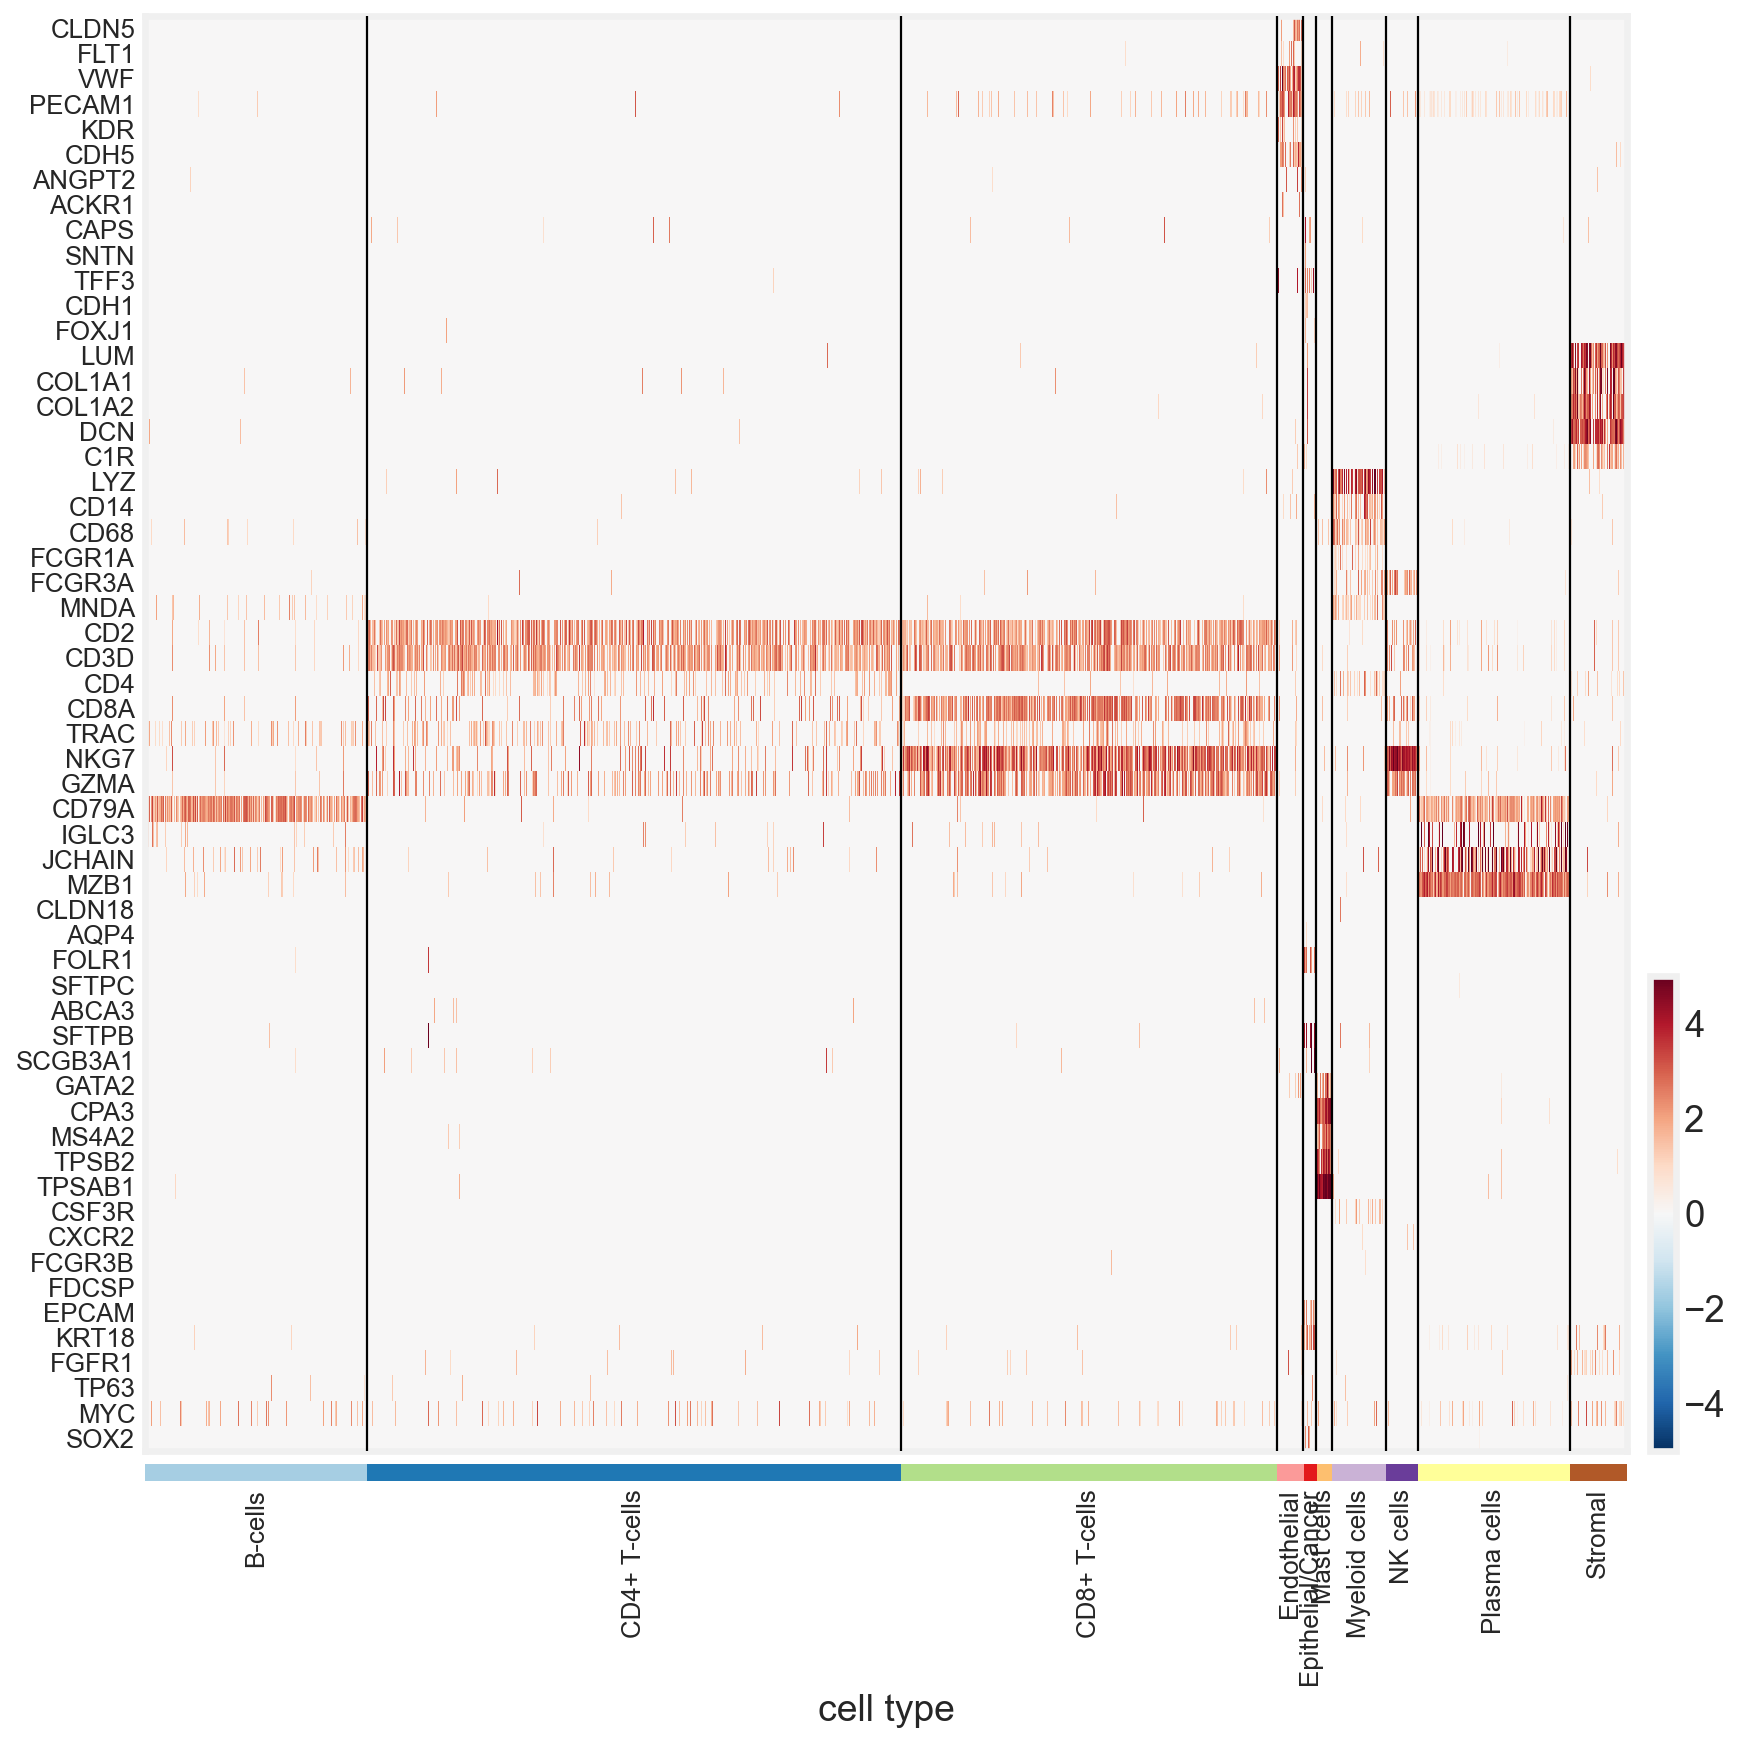

In [115]:
ax = sc.pl.heatmap(adata, list_of_markers, groupby='cell type', vmin=-5, vmax=5, cmap='RdBu_r', swap_axes=True, figsize=(11,11), show_gene_labels=True)

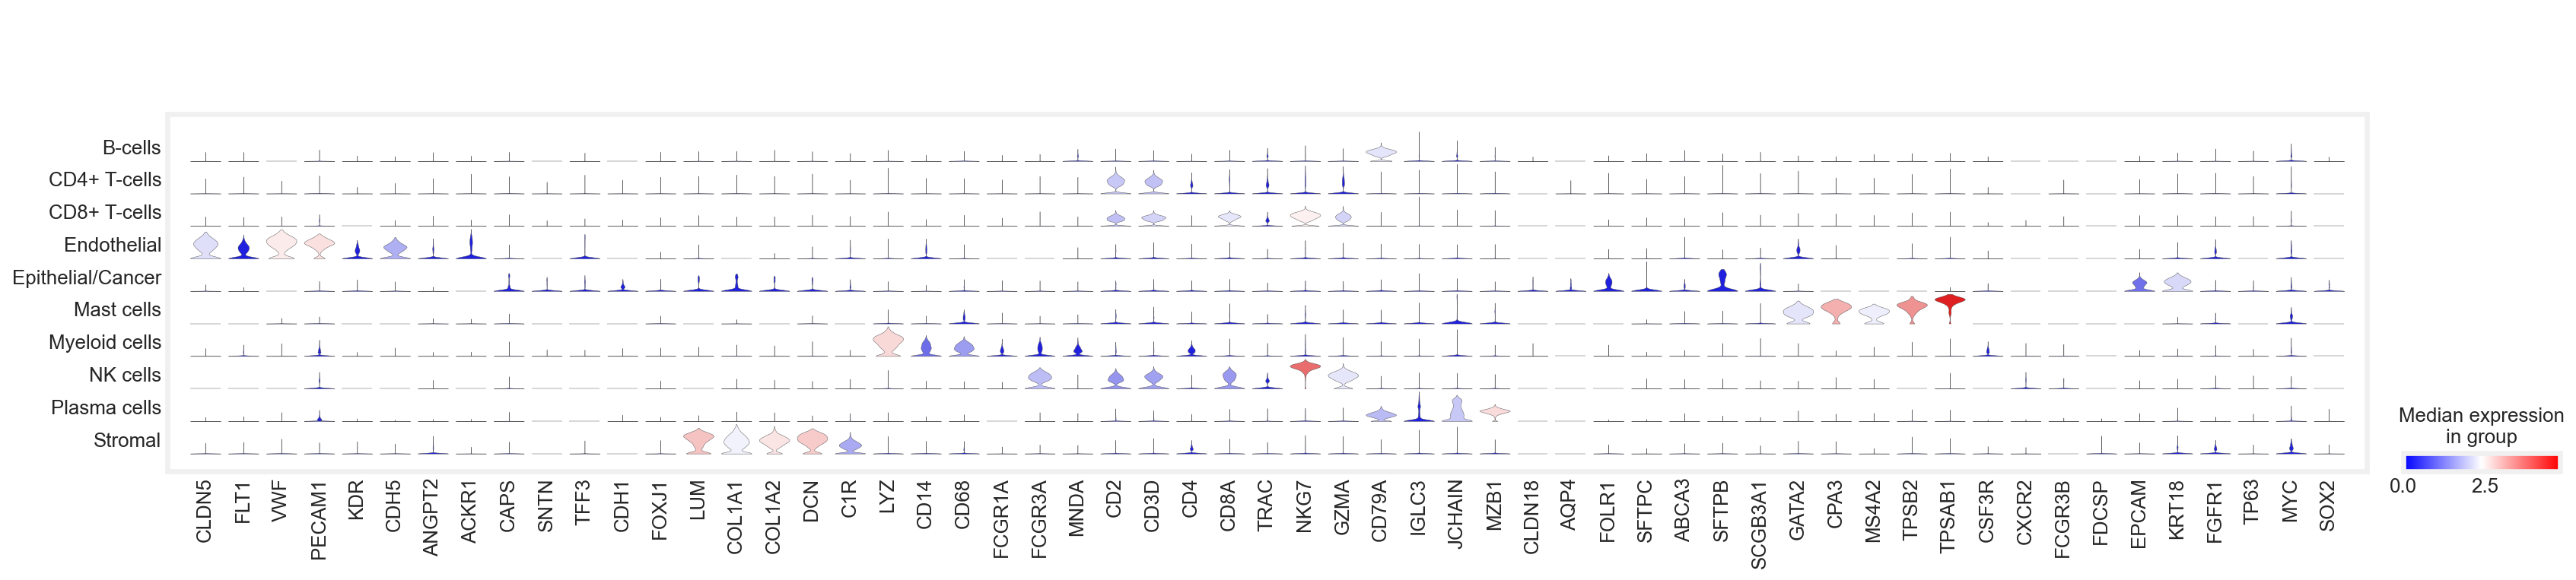

In [116]:
sc.pl.stacked_violin(adata, list_of_markers, groupby='cell type', cmap='bwr')

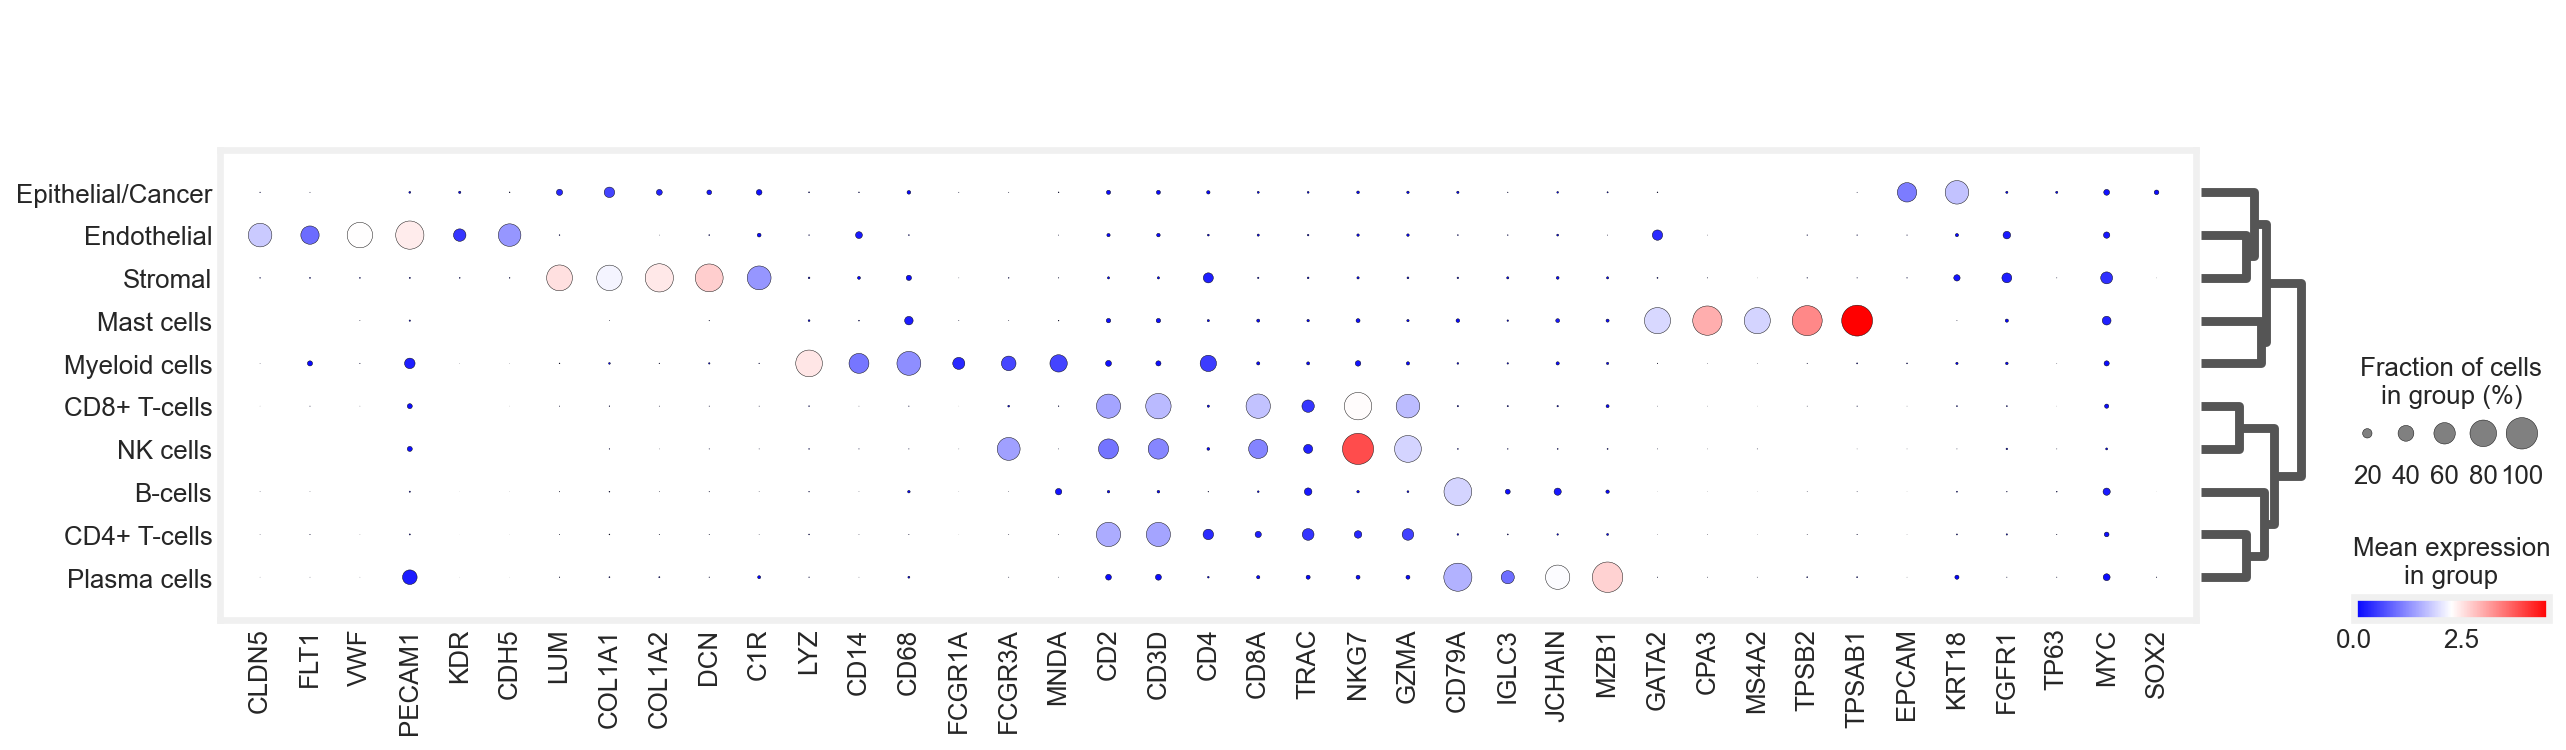

In [117]:
sc.pl.dotplot(adata, list_of_markers_2, groupby='cell type', cmap='bwr', dendrogram= True)